# Tiny ImageNet

Tiny ImageNet is a smaller subset of the ImageNet dataset designed for quick prototyping and experimentation. It is widely used in deep learning research and education due to its manageable size and complexity.

## Key Features
- **Number of Classes**: 200 classes, each corresponding to a specific object category.
- **Image Size**: All images are resized to 64x64 pixels, making it computationally efficient to train models.
- **Dataset Structure**:
  - **Training Set**: 100,000 images (500 per class).
  - **Validation Set**: 10,000 images (50 per class).
  - **Test Set**: 10,000 images (unlabeled).


## Dataset Organization
Tiny ImageNet is organized into folders:
- `train/`: Contains subfolders for each class with images for training.
- `val/`: Contains validation images and a CSV file `val_annotations.txt` with image-label mappings.
- `test/`: Contains test images (no labels provided).


https://www.kaggle.com/c/tiny-imagenet

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
RANDOM_SEED = 42
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 4096

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


Download files from https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet

In [4]:
default_path = "tiny-imagenet-200"
path_to_train_files = default_path + "/train"  # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/train"
path_to_val_files = default_path + "/val/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/val/images"
path_to_test_files = default_path + "/test/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/test/images"

In [5]:
unique_tiny_labels = os.listdir(path_to_train_files)

In [6]:
unique_labels = pd.read_csv(default_path + "/words.txt", sep='\t', 
                header=None, names=["class_id", "label"])
unique_labels.class_id = unique_labels.class_id.astype(str)
unique_labels = unique_labels.loc[unique_labels['class_id'].isin(unique_tiny_labels)]
unique_labels.sort_values(by="label", inplace=True)
unique_labels.reset_index(inplace=True, drop=True)
unique_labels = tf.convert_to_tensor(unique_labels)

In [7]:
train_files_pattern = os.path.join(path_to_train_files, '*', 'images', '*.JPEG')
train_ds_files = tf.data.Dataset.list_files(train_files_pattern, shuffle=True, seed=RANDOM_SEED)

In [8]:
val_files_pattern = os.path.join(path_to_val_files, '*.JPEG')
test_files_pattern = os.path.join(path_to_test_files, '*.JPEG')

val_ds_files = tf.data.Dataset.list_files(val_files_pattern)
test_ds = tf.data.Dataset.list_files(test_files_pattern)

In [9]:
val_labels = pd.read_csv(default_path + "/val/val_annotations.txt",  sep='\t', 
                header=None, names=["file_name", "class_id", "box_coord_1", "box_coord_2", "box_coord_3", "box_coord_4"])

In [10]:
val_labels = tf.convert_to_tensor(val_labels[["file_name", "class_id"]])

In [11]:
@tf.function
def load_image(filename, is_train_ds=True, scaled_version=True):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    
    if scaled_version:
        image = tf.image.convert_image_dtype(image, tf.float32)
        
    parts = tf.strings.split(filename, os.sep)

    if is_train_ds:
        label = parts[-3]  
    else:
        file_basename = parts[-1]  
        label = val_labels[tf.argmax(tf.equal(val_labels[:, 0], file_basename)), 1]
        
    #label = unique_labels[tf.argmax(tf.equal(unique_labels[:, 0], label)), 1] # if string label
    label = tf.argmax(tf.equal(unique_labels[:, 0], label)) # if as int
    
    return image, label

In [12]:
@tf.function
def apply_data_augmentation(image, label, scale_mode='0_1',  augmentation_type=None):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if augmentation_type == 'randaugment':
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        
        max_shift = 4
        image = tf.image.resize_with_crop_or_pad(image, IMG_HEIGHT + max_shift, IMG_WIDTH + max_shift)
        image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    if scale_mode == '0_1':
        image = tf.cast(image, tf.float32)
        image = tf.clip_by_value(image, 0.0, 1.0)
    else:
        image = tf.clip_by_value(image * 255, 0, 255)
        image = tf.round(image)
        image = tf.cast(image, tf.uint8)

    return image, label

In [13]:
def configure_performance(ds, is_train_ds=True, scale_mode="0_1", augmentation_type=None):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(lambda img, label: apply_data_augmentation(img, label, scale_mode=scale_mode, augmentation_type=augmentation_type), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
train_ds = configure_performance(train_ds_files.map(lambda fname: load_image(fname),num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=True, scale_mode="0_1", augmentation_type=None)
val_ds = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

train_ds_unscld = configure_performance(train_ds_files.map(lambda fname: load_image(fname, scaled_version=False), num_parallel_calls=tf.data.experimental.AUTOTUNE),  is_train_ds=True, scale_mode="0_255", augmentation_type=None)
val_ds_unscld = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False, scaled_version=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

In [15]:
image_batch, labels_batch = next(iter(train_ds))

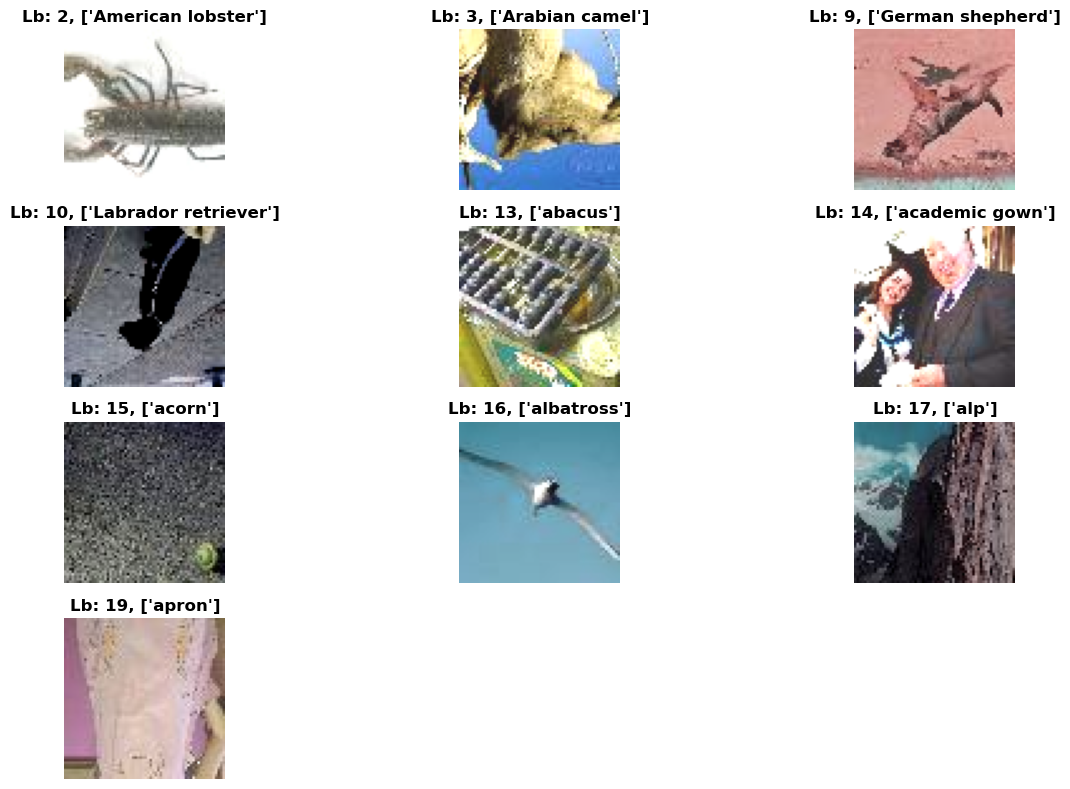

In [18]:
plt.figure(figsize=(12, 8))

for idx, label in enumerate(np.unique(labels_batch.numpy().astype(int).tolist())[:10]):
  ax = plt.subplot(4, 3, idx + 1)
  label_idx = tf.argmax(labels_batch.numpy() == label).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Lb: {label}, {unique_labels[label].numpy()[1].decode('utf-8').split(',')[0:1]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()
plt.show()

## Using a State-of-Art CNN Architecture

ConvNext V1:
https://arxiv.org/pdf/2201.03545

In [19]:
class StochasticDepth(tf.keras.layers.Layer):
    """ Aka Drop Path """
    def __init__(self, drop_path, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_path = drop_path

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

### Drop Path example

In [87]:
random_pic = next(iter(train_ds))
sample_img, sample_label = random_pic[0][0], random_pic[1][0]

In [100]:
drop_path = 0.3
keep_prob = 1 - drop_path
shape = (tf.shape(sample_img)[0],) + (1,) * (len(tf.shape(sample_img)) - 1)
random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
random_tensor = tf.floor(random_tensor)

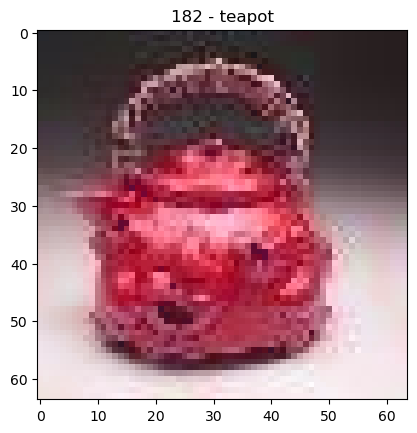

In [101]:
plt.imshow(sample_img)
plt.title(f"{sample_label} - {unique_labels[int(sample_label.numpy())][1].numpy().decode('utf-8')}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4285715].


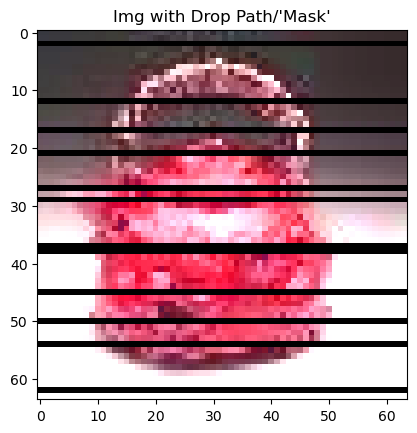

In [104]:
plt.imshow((sample_img / keep_prob) * random_tensor)
plt.title("Img with Drop Path/'Mask'")
plt.show()

In [105]:
class Block(tf.keras.Model):
    """ConvNeXt block.

    References:
        (1) https://arxiv.org/pdf/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.dim = dim
        if layer_scale_init_value > 0:
            self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        else:
            self.gamma = None
        self.dw_conv_1 = tf.keras.layers.Conv2D( 
            filters=dim, kernel_size=7, padding="same", groups=dim ## depthwise conv
        )
        # Groups: A positive int specifying the number of groups in which the input is split along the channel axis. 
        # Each group is convolved separately with filters // groups filters. The output is the concatenation of all the groups results along the channel axis. 
        # Input channels and filters must both be divisible by groups.

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.pw_conv_1 = tf.keras.layers.Dense(4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act_fn = tf.keras.layers.Activation("gelu") 
        self.pw_conv_2 = tf.keras.layers.Dense(dim)
        self.drop_path = (
            StochasticDepth(drop_path)
            if drop_path > 0.0
            else tf.keras.layers.Activation("linear")
        )

    def call(self, inputs):
        x = inputs

        x = self.dw_conv_1(x)
        x = self.layer_norm(x)
        x = self.pw_conv_1(x)
        x = self.act_fn(x)
        x = self.pw_conv_2(x)

        if self.gamma is not None:
            x = self.gamma * x

        return inputs + self.drop_path(x) # Residual Connection


In [114]:
def return_convnext_model(
    model_name="convnext_tiny",
    input_shape=(224, 224, 3),
    num_classes=200,
    depths=[3, 3, 27, 3],
    dims=[128, 256, 512, 1024],
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    ) -> tf.keras.Model:
    
    """Implements ConvNeXt Base given configurations. convnext_base_1k_224

    References:
        (1) https://arxiv.org/abs/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    inputs = tf.keras.layers.Input(input_shape)
    stem = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(dims[0], kernel_size=4, strides=4),
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
        ],
        name="stem",
    )

    downsample_layers = []
    downsample_layers.append(stem)
    for i in range(3):
        downsample_layer = tf.keras.Sequential(
            [
                tf.keras.layers.LayerNormalization(epsilon=1e-6),
                tf.keras.layers.Conv2D(dims[i + 1], kernel_size=2, strides=2),
            ],
            name=f"downsampling_block_{i}",
        )
        downsample_layers.append(downsample_layer)

    stages = []  # 4 feature resolution stages, each consisting of multiple residual blocks
    dp_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(4): 
        stage = tf.keras.Sequential(
            [
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                        name=f"convnext_block_{i}_{j}",
                    )
                    for j in range(depths[i])
                ]
            ],
            name=f"convnext_stage_{i}",
        )
        stages.append(stage)
        cur += depths[i]

    x = inputs
    for i in range(len(stages)):
        x = downsample_layers[i](x)
        x = stages[i](x)

    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    outputs = tf.keras.layers.Dense(num_classes, name="classification_head")(x)

    return tf.keras.Model(inputs, outputs, name=model_name)

In [122]:
model = return_convnext_model(drop_path_rate=0.5)

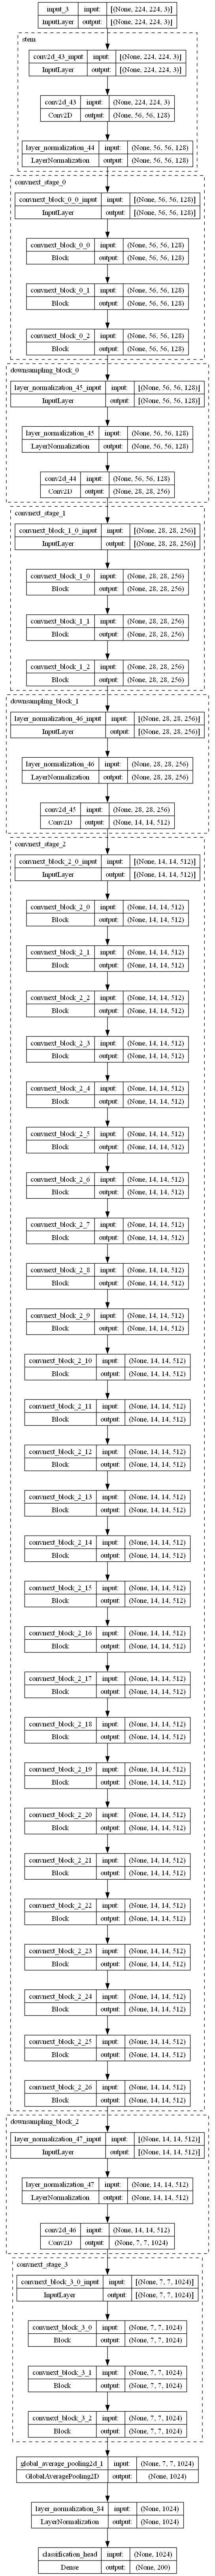

In [123]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [140]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0,
    warmup_target=4e-3,
    warmup_steps=500,
    decay_steps=6825,
    alpha=0.0
)

In [143]:
model.compile(
    #optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.05, ema_momentum=0.999),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [145]:
REQUIRED_HEIGHT = 224
REQUIERD_WIDTH = 224

In [157]:
@tf.function
def resize_img(img, label):
    return tf.image.resize(img, (REQUIRED_HEIGHT, REQUIERD_WIDTH), method=tf.image.ResizeMethod.BICUBIC), label

In [158]:
train_ds = train_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [144]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
)

Epoch 1/300


ResourceExhaustedError: Graph execution error:

Detected at node 'convnext_tiny/convnext_stage_2/convnext_block_2_1/conv2d_54/PartitionedCall' defined at (most recent call last):
    File "c:\Users\Dani\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Dani\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Dani\anaconda3\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Dani\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Dani\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Dani\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Dani\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Dani\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Dani\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Dani\AppData\Local\Temp\ipykernel_21068\4165895712.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dani\AppData\Local\Temp\ipykernel_21068\2125474550.py", line 36, in call
      x = self.dw_conv_1(x)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dani\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 279, in call
      outputs = self._jit_compiled_convolution_op(
Node: 'convnext_tiny/convnext_stage_2/convnext_block_2_1/conv2d_54/PartitionedCall'
Out of memory while trying to allocate 4194304 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    4.10MiB
              constant allocation:         0B
        maybe_live_out allocation:    8.10MiB
     preallocated temp allocation:    4.10MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   12.19MiB
              total fragmentation:       136B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 4.00MiB
		Operator: op_type="Conv2D" op_name="Conv2D" source_file="c:\\Users\\Dani\\anaconda3\\lib\\site-packages\\keras\\layers\\convolutional\\base_conv.py" source_line=255
		XLA Label: custom-call
		Shape: f32[128,4,4,512]
		==========================

	Buffer 2:
		Size: 4.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: copy
		Shape: f32[128,4,4,512]
		==========================

	Buffer 3:
		Size: 4.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[128,4,4,512]
		==========================

	Buffer 4:
		Size: 98.0KiB
		Operator: op_name="XLA_Args"
		XLA Label: copy
		Shape: f32[7,7,1,512]
		==========================

	Buffer 5:
		Size: 98.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[7,7,1,512]
		==========================

	Buffer 6:
		Size: 24B
		XLA Label: tuple
		Shape: (f32[128,4,4,512], f32[128,4,4,512], f32[7,7,1,512])
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_type="Conv2D" op_name="Conv2D" source_file="c:\\Users\\Dani\\anaconda3\\lib\\site-packages\\keras\\layers\\convolutional\\base_conv.py" source_line=255
		XLA Label: custom-call
		Shape: (f32[128,4,4,512], u8[0])
		==========================


	 [[{{node convnext_tiny/convnext_stage_2/convnext_block_2_1/conv2d_54/PartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_53278]

# Cross-validation on 3 StratifiedKFold